In [1]:
import sys
from pathlib import Path

cwd = Path.cwd().resolve().parent
sys.path.append(str(cwd))


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import optimize

import utils as u
from visualization import papermode
from visualization import can_viz as canv

papermode(plt, size=18)


In [3]:
abbr = "P11"
filename = u.get_filename(abbr)
basename = u.get_basename(filename)
rundir = u.get_rundir(basename)

datadir = cwd / rundir
temp_data_path = datadir / "temp"
can_path = u.find_canlog(datadir)

figdir = cwd / "figs" / "thesis" / "experimental-setup"


In [4]:
can_df = u.read_canlog(can_path)
canL_df = can_df[can_df.frameID == '501'].copy()
canR_df = can_df[can_df.frameID == '502'].copy()

canL_df["packet"] = canL_df.can_packet.str[4:]
canR_df["packet"] = canR_df.can_packet.str[4:]

u.decompose_packet(canL_df, "packet")
u.decompose_packet(canR_df, "packet")

canL_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canL.csv", index=False)
canR_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canR.csv", index=False)

In [5]:
heatL_path = temp_data_path / f"{basename}_temp_left_drive_status_heatsink_temperature.csv"
heatR_path = temp_data_path / f"{basename}_temp_right_drive_status_heatsink_temperature.csv"
motorL_path = temp_data_path / f"{basename}_temp_left_drive_status_motor_temperature.csv"
motorR_path = temp_data_path / f"{basename}_temp_right_drive_status_motor_temperature.csv"

heatL_df = pd.read_csv(heatL_path)
heatR_df = pd.read_csv(heatR_path)
motorL_df = pd.read_csv(motorL_path)
motorR_df = pd.read_csv(motorR_path)

In [6]:
heatL_df = heatL_df.rename(columns={"/left_drive/status/heatsink_temperature": "hL"})
heatR_df = heatR_df.rename(columns={"/right_drive/status/heatsink_temperature": "hR"})
motorL_df = motorL_df.rename(columns={"/left_drive/status/motor_temperature": "mL"})
motorR_df = motorR_df.rename(columns={"/right_drive/status/motor_temperature": "mR"})


In [7]:
time_min_heat = min(heatL_df.time.min(), heatR_df.time.min())
time_min_motor = min(motorL_df.time.min(), motorR_df.time.min())
time_min = min(time_min_heat, time_min_motor)

time_max_heat = max(heatL_df.time.max(), heatR_df.time.max())
time_max_motor = max(motorL_df.time.max(), motorR_df.time.max())
time_max = max(time_max_heat, time_max_motor)

reltime_max = time_max - time_min


In [8]:
heatL_df["time_rel"] = heatL_df.time - time_min
heatR_df["time_rel"] = heatR_df.time - time_min
motorL_df["time_rel"] = motorL_df.time - time_min
motorR_df["time_rel"] = motorR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min


In [9]:
canL_mask = (canL_df.time_rel > 0) & (canL_df.time < time_max)
canL_df = canL_df[canL_mask].copy()

canR_mask = (canR_df.time_rel > 0) & (canR_df.time < time_max)
canR_df = canR_df[canR_mask].copy()


In [10]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(heatL_df.time_rel, heatL_df.hL, label="Left")
ax1.plot(heatR_df.time_rel, heatR_df.hR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Heatsink\nTemperature", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax1.set_ylim(bottom=0)

ax2.plot(canL_df.time_rel, canL_df.b6, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b6, label="Right")
ax2.legend(fontsize=12)
ax2.set_ylabel("Byte value\ntransmitted\nthrough\nthe \\texttt{CAN} bus", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.set_ylim(bottom=0)

ax2.set_xlim((0, 80))

fig.supxlabel("Time (s)", fontsize=18)


Text(0.5, 0.01, 'Time (s)')

Text(0.5, 0.01, 'Time (s)')

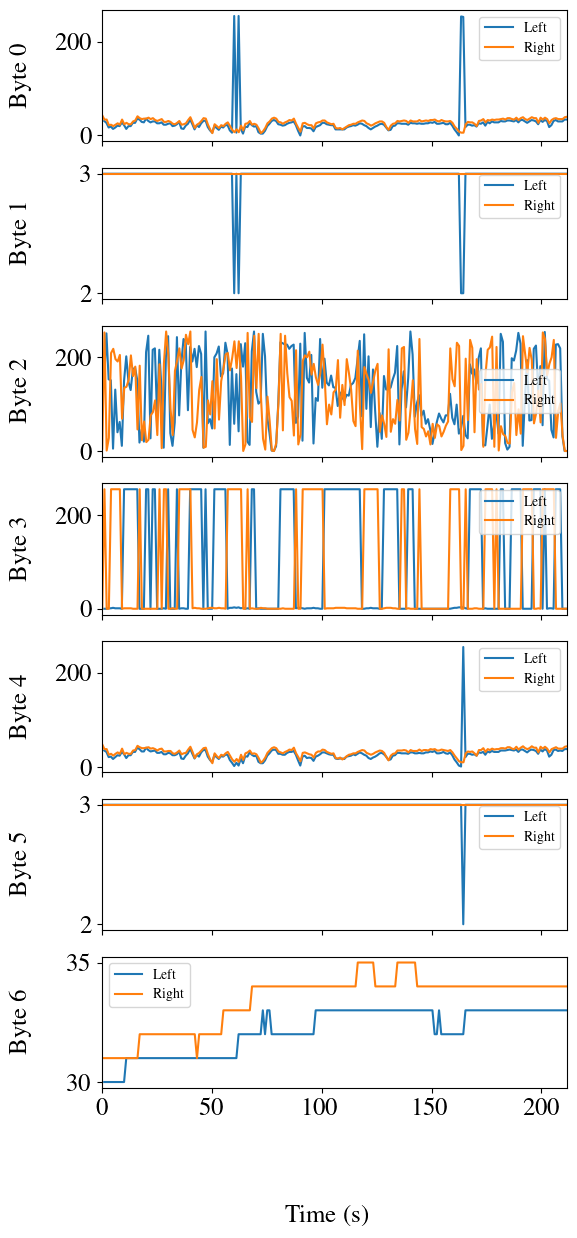

In [11]:
fig, subfigs = plt.subplots(nrows=7, sharex=True, figsize=(6,14))
for idx, ax in enumerate(subfigs.reshape(-1)):
    ax.plot(canL_df.time_rel, canL_df[f"b{idx}"], label="Left")
    ax.plot(canR_df.time_rel, canR_df[f"b{idx}"], label="Right")
    ax.set_ylabel(f"Byte ${{{idx}}}$")
    ax.legend(fontsize=10)
    ax.yaxis.set_label_coords(-0.15, 0.5)

ax.set_xlim((0, reltime_max))

fig.supxlabel("Time (s)", fontsize=18)

Text(0.5, 0.01, 'Time (s)')

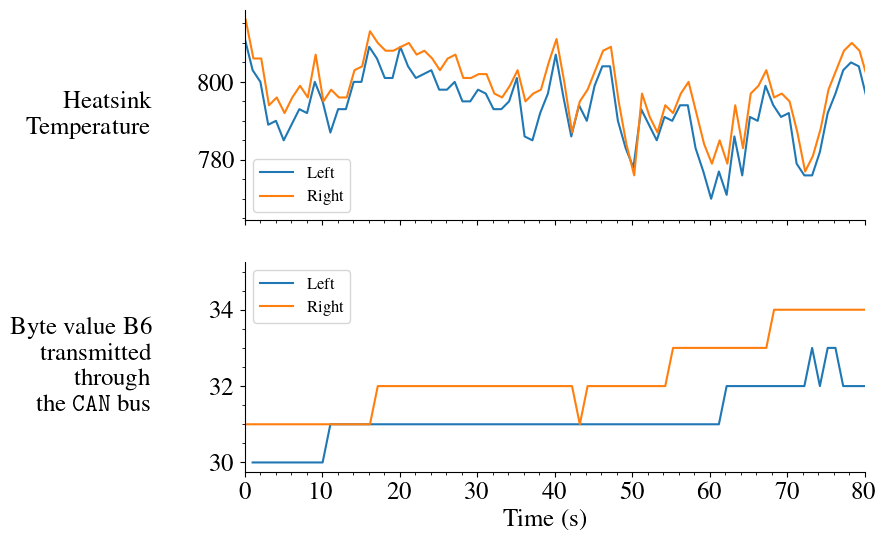

In [12]:
fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

ax1.plot(motorL_df.time_rel, motorL_df.mL, label="Left")
ax1.plot(motorR_df.time_rel, motorR_df.mR, label="Right")
ax1.legend(fontsize=12)
ax1.set_ylabel("Heatsink\nTemperature", rotation=0, ha="right", va="center")
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.spines[["right", "top"]].set_visible(False)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax1.set_ylim(bottom=0)

ax2.plot(canL_df.time_rel, canL_df.b6, label="Left")
ax2.plot(canR_df.time_rel, canR_df.b6, label="Right")
ax2.legend(fontsize=12)
ax2.set_ylabel("Byte value B6\ntransmitted\nthrough\nthe \\texttt{CAN} bus", rotation=0, ha="right", va="center")
ax2.yaxis.set_label_coords(-0.15, 0.5)
ax2.spines[["right", "top"]].set_visible(False)
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax2.set_ylim(bottom=0)

ax2.set_xlim((0, 80))

fig.supxlabel("Time (s)", fontsize=18)